In [25]:
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

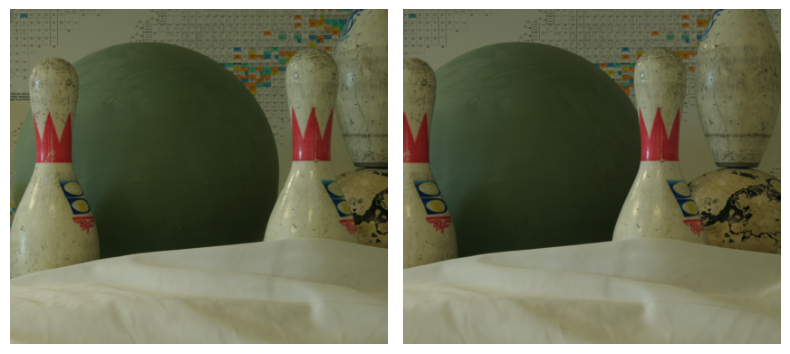

In [31]:
path = Path.home() / 'OneDrive - Seagroup/personal/AIO/research/MiddleburyDataset/Bowling1/Illum2/Exp1'
left_img_path = str(path / 'view1.png')
right_img_path = str(path / 'view5.png')

plt.figure(figsize=(8, 4))
for i, image_path in enumerate([left_img_path, right_img_path]):
    ax = plt.subplot(1, 2, i + 1)
    ax.imshow(Image.open(str(image_path)))
    ax.axis('off')
plt.tight_layout()

In [38]:
l_gray_img = np.array(Image.open(left_img_path).convert('L'))
r_gray_img = np.array(Image.open(right_img_path).convert('L'))
r_gray_img.shape, l_gray_img.shape

((370, 417), (370, 417))

In [52]:
def block_matching(right_image, left_image, kernel_window=1, metric='SAD'):
    kernel_centre = int((kernel_window - 1) / 2)
    disparity_map = []
    for i in tqdm(range(kernel_centre, right_image.shape[0] - kernel_centre)):
        for rj in range(kernel_centre, right_image.shape[1] - kernel_centre):
            diff_list = []
            window_h = i - kernel_centre, i + kernel_centre + 1
            window_w =  rj - kernel_centre, rj + kernel_centre + 1
            r_window = right_image[window_h[0]:window_h[1], window_w[0]:window_w[1]]
            for lj in range(kernel_centre, l_gray_img.shape[1] - kernel_centre):
                window_w = lj - kernel_centre, lj + kernel_centre + 1
                l_window = left_image[window_h[0]:window_h[1], window_w[0]:window_w[1]]

                if metric == 'SAD':
                    diff = np.sum(np.absolute(np.subtract(r_window, l_window)))
                else:
                    diff = np.sum(np.multiply(np.subtract(r_window, l_window), np.subtract(r_window, l_window)))
                diff_list.append(diff)

            idx_min = diff_list.index(min(diff_list)) + kernel_centre
            disparity_map.append(idx_min - rj)
    return np.reshape(np.array(disparity_map), (right_image.shape[0] - kernel_window + 1, right_image.shape[1] - kernel_window + 1))

In [53]:
meta = {}
for i in [1, 5, 9]:
    meta[i] = block_matching(r_gray_img, l_gray_img, i, 'SAD')

plt.figure(figsize=(8, 4))
for i, arr in enumerate(meta):
    ax = plt.subplot(1, len(meta), i + 1)
    ax.imshow(meta[arr], 'gray')
    ax.axis('off')
plt.tight_layout()

100%|██████████| 366/366 [03:31<00:00,  1.73it/s]


100%|██████████| 366/366 [04:21<00:00,  1.40it/s]


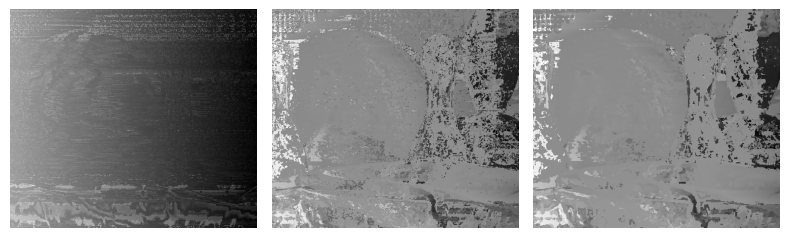

In [73]:
meta = {}
for i in [1, 5, 9]:
    meta[i] = block_matching(r_gray_img, l_gray_img, i, 'SSD')

plt.figure(figsize=(8, 4))
for i, arr in enumerate(meta):
    ax = plt.subplot(1, len(meta), i + 1)
    ax.imshow(meta[arr], 'gray')
    ax.axis('off')
plt.tight_layout()

In [55]:
kernel, max_offset = 3, 32

w, h = l_gray_img.shape
depth = np.zeros((w, h), np.uint8)
depth.shape = h, w

kernel_half = int(kernel / 2)
offset_adjust = 255 / max_offset  # this is used to map depth map output to 0-255 range

for y in tqdm(range(kernel_half, h - kernel_half)):
    for x in range(kernel_half, w - kernel_half):
        best_offset = 0
        prev_ssd = 65534

        for offset in range(max_offset):
            ssd = 0
            ssd_temp = 0

            # v and u are the x,y of our local window search, used to ensure a good match
            # because the squared differences of two pixels alone is not enough ot go on
            for v in range(-kernel_half, kernel_half + 1):
                for u in range(-kernel_half, kernel_half + 1):
                    # iteratively sum the sum of squared differences value for this block
                    # left[] and right[] are arrays of uint8, so converting them to int saves
                    # potential overflow
                    ssd_temp = int(l_gray_img[y + v, x + u]) - int(r_gray_img[y + v, (x + u) - offset])
                    ssd += ssd_temp * ssd_temp

            # if this value is smaller than the previous ssd at this block
            # then it's theoretically a closer match. Store this value against
            # this block..
            if ssd < prev_ssd:
                prev_ssd = ssd
                best_offset = offset

        depth[y, x] = best_offset * offset_adjust

Image.fromarray(depth)

 89%|████████▊ | 368/415 [00:22<00:02, 16.48it/s]


IndexError: index 370 is out of bounds for axis 0 with size 370

In [72]:
for y in tqdm(range(kernel_half, h - kernel_half)):
    for x in range(kernel_half, w - kernel_half):
        for offset in range(max_offset):
            ssd = 0
            ssd_temp = 0

            # v and u are the x,y of our local window search, used to ensure a good match
            # because the squared differences of two pixels alone is not enough ot go on
            for v in range(-kernel_half, kernel_half + 1):
                for u in range(-kernel_half, kernel_half + 1):
                    print([y + v, x + u], [y + v, (x + u) - offset])
        break
    break

  0%|          | 0/415 [00:00<?, ?it/s]

[0, 0] [0, 0]
[0, 1] [0, 1]
[0, 2] [0, 2]
[1, 0] [1, 0]
[1, 1] [1, 1]
[1, 2] [1, 2]
[2, 0] [2, 0]
[2, 1] [2, 1]
[2, 2] [2, 2]
[0, 0] [0, -1]
[0, 1] [0, 0]
[0, 2] [0, 1]
[1, 0] [1, -1]
[1, 1] [1, 0]
[1, 2] [1, 1]
[2, 0] [2, -1]
[2, 1] [2, 0]
[2, 2] [2, 1]
[0, 0] [0, -2]
[0, 1] [0, -1]
[0, 2] [0, 0]
[1, 0] [1, -2]
[1, 1] [1, -1]
[1, 2] [1, 0]
[2, 0] [2, -2]
[2, 1] [2, -1]
[2, 2] [2, 0]
[0, 0] [0, -3]
[0, 1] [0, -2]
[0, 2] [0, -1]
[1, 0] [1, -3]
[1, 1] [1, -2]
[1, 2] [1, -1]
[2, 0] [2, -3]
[2, 1] [2, -2]
[2, 2] [2, -1]
[0, 0] [0, -4]
[0, 1] [0, -3]
[0, 2] [0, -2]
[1, 0] [1, -4]
[1, 1] [1, -3]
[1, 2] [1, -2]
[2, 0] [2, -4]
[2, 1] [2, -3]
[2, 2] [2, -2]
[0, 0] [0, -5]
[0, 1] [0, -4]
[0, 2] [0, -3]
[1, 0] [1, -5]
[1, 1] [1, -4]
[1, 2] [1, -3]
[2, 0] [2, -5]
[2, 1] [2, -4]
[2, 2] [2, -3]
[0, 0] [0, -6]
[0, 1] [0, -5]
[0, 2] [0, -4]
[1, 0] [1, -6]
[1, 1] [1, -5]
[1, 2] [1, -4]
[2, 0] [2, -6]
[2, 1] [2, -5]
[2, 2] [2, -4]
[0, 0] [0, -7]
[0, 1] [0, -6]
[0, 2] [0, -5]
[1, 0] [1, -7]
[1, 1] [1, -6

In [68]:
w

370